От сотрудников Института Цитологии и Генетики СО РАН были получены данные о продолжительности жизни больных с боковым амиотрофическим склерозом(болезнь Стивена Хокинга), 
где Omega stability - некоторое значение, соответствующее мутации в белке, а Survival time - продолжительность жизни пациента при этой мутации.

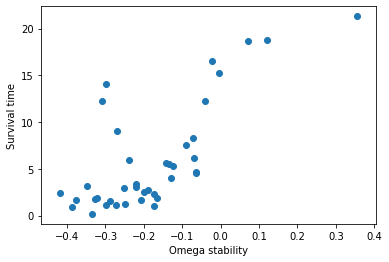

In [3]:
# Загрузим данные с помощью модуля Pandas в объект DataFrame
import numpy as np
import pandas as pd
omega_stability = pd.read_csv('omega_stability.csv')

# Проведем первичную обработку данных
omega_stability = omega_stability.T
omega_stability = omega_stability.drop(index = "Name")
omega_stability.columns = ["Omega stability", "Survival time"]

# Преобразуем значения ячеек в числовые
omega_stability["Omega stability"] = omega_stability["Omega stability"].astype(float)
omega_stability["Survival time"] = omega_stability["Survival time"].astype(float)

x = omega_stability["Omega stability"].values
y = omega_stability["Survival time"].values

# Проведем сортировку данных 
x, y = zip(*sorted(zip(x, y)))
x = np.asarray(x)
y = np.asarray(y)

# Проведем визуализацию
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_xlabel('Omega stability')
ax.set_ylabel('Survival time')
ax.scatter(x, y)

Поставлена задача определить оптимальную регрессионную модель для прогнозирования времени дожития пациентов с БАС.

Будут рассмотрены следующие функции:
1. Линейная $$f(x) = a_{0} + a_{1}x$$
2. Кубическая $$f(x) = a_{0} + a_{1}x + a_{2}x^{2} + a_{3}x^{3}$$
3. Логистическая $$f(x) = \frac{a_{0}}{1 + e^{-a_{1}(x-a_{2})}}$$

In [4]:
# Проведем оценку параметров обычным МНК для линейной функции
np.polyfit(x, y, 1)[::-1]

array([10.90182755, 27.48041546])

In [5]:
# Проведем оценку параметров обычным МНК для кубической функции
np.polyfit(x, y, 3)[::-1]

array([  12.09694903,   49.76389461,    4.505014  , -179.41888585])

[2.47742715e+01 8.04350708e+00 5.72397837e-03]


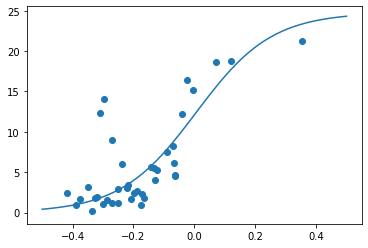

In [6]:
# Проведем оценку параметров нелинейным МНК для логистической функции
def logistic(a, x):
    return a[0]/(1 + np.exp(-a[1]*(x-a[2])))
# Функция остатков
def logistic_residual(a, x, y):
    return logistic(a, x) - y
from scipy.optimize import least_squares
a = least_squares(logistic_residual, np.ones(3), loss='linear', args=(x, y)).x
print(a)
fig, ax = plt.subplots()
x_plot = np.linspace(-0.5, 0.5, num=1000)
y_plot = logistic(a, x_plot)
ax.plot(x_plot, y_plot)
ax.scatter(x, y)

Далее необходимо создать метрику для оценки качества выбранной модели. Будем применять алгоритм перекрестной проверки
по К-группам. Тестовую выборку возьмем за 30% от изначальной. В результате получаем перспективную ошибку предсказания при тестировании модели на независимых данных.

In [11]:
# Кросс-валидация для линейной модели
def cv_linear(x, y, polyn_degree, k_percent):
    from sklearn.model_selection import KFold
    import numpy as np
    k = int(k_percent*len(x))
    kf = KFold(n_splits=k)
    error = 0
    for train_index, test_index in kf.split(x):
        a = np.polyfit(x[train_index], y[train_index], polyn_degree)
        y_pred = np.polyval(a, x[test_index])
        y_exac = y[test_index]
        error += np.sqrt(np.sum(np.square(y_pred - y_exac))/len(test_index))
    error /= k
    return error


In [19]:
cv_linear(x, y, 1, 0.3)

4.160264480407327

In [20]:
cv_linear(x, y, 3, 0.3)

15.762327542048132

Подведем промежуточный итог: 
1. Значение кросс-валидации для линейной модели является приемлемым.
2. Кубическая модель требует дальнейшего исследования и применения устойчивых методов оценивания 
для снижения влияния "неправильных измерений"

In [59]:
# Кросс-валидация для нелинейной модели
def cv_nonlinear(x, y, model_func, k_percent, loss, x0):
    from sklearn.model_selection import KFold
    from scipy.optimize import least_squares
    import numpy as np
    residual_func = lambda a, x, y: model_func(a, x) - y
    k = int(k_percent*len(x))
    kf = KFold(n_splits=k)
    error = 0
    for train_index, test_index in kf.split(x):
        #print("TRAIN:", train_index, "TEST:", test_index)
        a = least_squares(residual_func, x0, loss=loss, args=(x[train_index], y[train_index])).x
        y_pred = model_func(a, x[test_index])
        y_exac = y[test_index]
        error_loc = np.sqrt(np.sum(np.square(y_pred - y_exac))/len(test_index))
        if error_loc > 50:
            import matplotlib.pyplot as plt
            fig, ax = plt.subplots()
            x_plot = np.linspace(-0.5, 0.5, num=1000)
            y_plot = model_func(a, x_plot)
            ax.plot(x_plot, y_plot)
            ax.scatter(x, y)
        #print(error_loc)
        error += error_loc
    error /= k
    return error

17.792317029209865

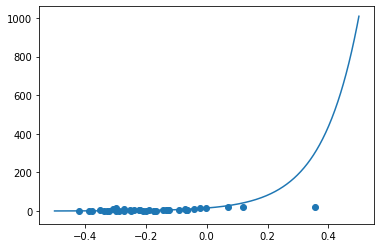

In [62]:
# Кросс-валидация для логистиечкой модели с переменной асиимптотой
cv_nonlinear(x, y, logistic, 0.3, 'huber', np.ones(3))

Значение кросс-валидации для логистической модели с переменным верхним пределом неприемлемо. 
Требуется дальнейшее исследование.

In [60]:
# Логистическая функция с зафиксированной верхней асимптотой
def logistic_new(a, x):
    return 21.3/(1 + np.exp(-a[0]*(x-a[1])))
cv_nonlinear(x, y, logistic_new, 0.3, 'huber', np.ones(2))

3.284184118851732

10.096677723649965

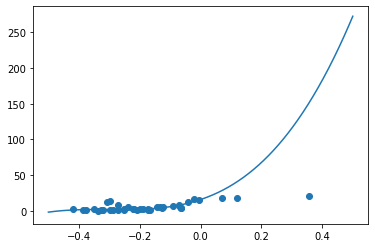

In [61]:
def cube(a, x):
    import numpy as np
    p = np.poly1d(a[::-1])
    return p(x)
cv_nonlinear(x, y, cube, 0.3, 'huber', np.ones(4))